In [1]:
import numpy as np
import math

DATA_PATH='./docword.nips.txt'

# 1. Parse data
Create a list for every document. List index corresponds to word\_ID-1. Every position stores the count. For this notebook I have used NIPS full papers data.

In [2]:
def parse_data(filename):
    docs=[]
    lines = open(filename, "r").readlines()
    
    doc_num, word_num=int(lines[0].strip()), int(lines[1].strip())
    
    docs=[[0 for _ in range(word_num)] for _ in range(doc_num)]
    for line in lines[3:]:
        tokens = line.strip().split()
        doc_id, word_id, count = int(tokens[0])-1, int(tokens[1])-1, int(tokens[2])
        docs[doc_id][word_id]=count
    
    return np.array(docs)



In [3]:
docs=parse_data(DATA_PATH)
print(docs.shape)


(1500, 12419)


# 2. Compute TF-IDF to extract features of each document
### Compute term frequency
$$
TF_w=\frac{count_w}{total\_words\_count}\\
$$
>count_w = Number of repetitions of word in a document  
>total\_words\_count = Number of words in a document  
### Compute inverse document frequency
$$
IDF_w=\log(\frac{docs\_count}{docs\_count_w + 1})\\
$$
>docs\_count = Number of documents  
>docs\_count_w = Number of documents containing the word  
>hint: Adding 1 to the denominator is to avoid denominator becoming 0 when none of the documents contains the word
### Compute TF-IDF_w
$$
TF-IDF_w = TF_w * IDF_w
$$


In [4]:
def compute_TF_IDF(docs):
    docs_copy=np.copy(docs)
    docs_num, words_num = docs.shape

    #compute TF
    total_words_count=np.array([np.sum(docs[d]) for d in range(docs_num)])
    tf=docs.T/total_words_count
    #print(tf.T)

    #compute IDF
    idf=[]
    for word in docs_copy.T:
        idf_w=math.log(docs_num/(np.count_nonzero(word)+1))
        idf.append(idf_w)
    idf=np.array(idf) 
    #print(idf)

    #compute TF-IDF
    tf_idf=tf.T*idf
    #print(tf_idf)

    return tf_idf
    
    

In [5]:
features=compute_TF_IDF(docs)

## 3. Compute cosine similarity
I've already got an TF-IDFs matrix for the dataset. Even though a TF-IDFs vector can represent a document as its feature, the matrix is sparse and overly high-dimensional. Thus, I decide to compute cosine similarity matrix based on TF-IDFs matrix to generate a more compact and lower-dimensional feature matrix for clustering.  
$$
sim(\mathcal{x}, \mathcal{y})=\frac{\mathcal{x}\cdot\mathcal{y}}{|\mathcal{x}||\mathcal{y}|}
$$


>Besides, it also makes sense to compute cosine similarity based on term frequency which is easily to get from the raw dataset. Why do I choose TF-IDF instead? The reason I need IDF is to help correct for words commonly appearing in the majority of the documents. These words are irrepresensitive, so they do little in clustering. Their TF-IDF values would be close to 0. Thus, TF-IDF is a more represensitive feature form than term frequency.

In [6]:
def compute_cos_sim(features):
    docs_num, words_num = features.shape
    cos_sim=np.zeros((docs_num, docs_num))
    for i in range(docs_num):
        for j in range(docs_num):
            x_euc=math.sqrt(np.dot(features[i],features[i].T))
            y_euc=math.sqrt(np.dot(features[j],features[j].T))
            x_dot_y=np.dot(features[i], features[j].T)
            cos_sim[i][j]=x_dot_y/(x_euc*y_euc)
    return cos_sim

In [7]:
cos_sim=compute_cos_sim(features)
print(cos_sim)

[[1.         0.04588239 0.03825339 ... 0.01957959 0.03269325 0.02197542]
 [0.04588239 1.         0.03379465 ... 0.02614713 0.0178029  0.00901966]
 [0.03825339 0.03379465 1.         ... 0.0442376  0.07386919 0.00267142]
 ...
 [0.01957959 0.02614713 0.0442376  ... 1.         0.25999627 0.05291071]
 [0.03269325 0.0178029  0.07386919 ... 0.25999627 1.         0.0088009 ]
 [0.02197542 0.00901966 0.00267142 ... 0.05291071 0.0088009  1.        ]]


## 4. Use PCA to do dimensionality reduction
After computing cosine similarity, my dataset to be clustered still has 1500-dimensinal features (for nips text collection). Clustering methods, and also visualization, cannot work well with such high-dimensional data. Thus, I need to project the data from the original high dimensional space into a lower dimensional space. Subsequently, I use PCA to project into a 2-dimensional space, cluster the data and plot the results in 2-dimensional space.  

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data=pca.fit_transform(cos_sim)
print(np.sum(pca.explained_variance_ratio_))
print(reduced_data)
print(reduced_data.shape)

0.1525500491045877
[[-0.19042356  0.27364248]
 [ 0.05040628  0.58729902]
 [-0.03040297 -0.01634176]
 ...
 [-0.54587293 -0.40641944]
 [-0.49079126 -0.05316274]
 [-0.05451733 -0.74261872]]
(1500, 2)


To see how much information losing after PCA, I check the combined <em>explained variance ratio</em> of each component in the PCA result. It is 15%, which means only 15% of the original information remains. It seems not good. However, I will still perform clustering on data before PCA and compare the performances.

## 5. Clustering
I choose 3 clustering methods: DBSCAN, K-Means, and AgglomerativeClustering.

### 5.1 DBSCAN
For DBSCAN, we don't have to assign number of clusters ahead. In fact, we actually don't know how many clusters there are, either. Thus, I perform DBSCAN first to see how many clusters it generates and take it as a reference.

In [9]:
from sklearn.cluster import DBSCAN

#input is similarity matrix
dbscan_sim = DBSCAN(eps=1.55, min_samples=7).fit(cos_sim)
labels_db_sim = dbscan_sim.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_db_sim = len(set(labels_db_sim)) - (1 if -1 in labels_db_sim else 0)
n_noise_db_sim = list(labels_db_sim).count(-1)

print(labels_db_sim)
print(n_clusters_db_sim, n_noise_db_sim)


[0 1 0 ... 0 0 0]
7 97


In [10]:
#input is features produced by PCA
dbscan_pca = DBSCAN(eps=0.073, min_samples=4).fit(reduced_data)

core_samples_mask = np.zeros_like(dbscan_pca.labels_, dtype=bool)
core_samples_mask[dbscan_pca.core_sample_indices_] = True


labels_db_pca = dbscan_pca.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_db_pca = len(set(labels_db_pca)) - (1 if -1 in labels_db_pca else 0)
n_noise_db_pca = list(labels_db_pca).count(-1)


print(labels_db_pca)
print(n_clusters_db_pca, n_noise_db_pca)

[ 0  0  0 ... -1  0  0]
7 72


### 5.2 K-Means


In [11]:
from sklearn.cluster import KMeans

#input is similarity matrix
kmeans_sim = KMeans(init='k-means++', n_clusters=7, random_state=0)
kmeans_sim.fit(cos_sim)
labels_km_sim=kmeans_sim.labels_
n_clusters_km_sim = len(set(labels_km_sim)) - (1 if -1 in labels_km_sim else 0)


print(labels_km_sim)
print(n_clusters_km_sim)

[4 1 3 ... 3 3 5]
7


In [12]:
#input is features produced by PCA
kmeans_pca = KMeans(init='k-means++', n_clusters=7, random_state=0)
kmeans_pca.fit(reduced_data)
labels_km_pca=kmeans_sim.labels_
n_clusters_km_pca = len(set(labels_km_pca)) - (1 if -1 in labels_km_pca else 0)


print(labels_km_pca)
print(n_clusters_km_pca)


[4 1 3 ... 3 3 5]
7


### 5.3 Agglomerative Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

#input is similarity matrix
ac_sim = AgglomerativeClustering(n_clusters=7).fit(cos_sim)
labels_ac_sim=ac_sim.labels_
n_clusters_ac_sim = len(set(labels_ac_sim)) - (1 if -1 in labels_ac_sim else 0)


print(labels_ac_sim)
print(n_clusters_ac_sim)

[1 4 2 ... 2 2 5]
7


In [14]:
#input is features produced by PCA
ac_pca = AgglomerativeClustering(n_clusters=7).fit(reduced_data)
labels_ac_pca=ac_pca.labels_
n_clusters_ac_pca = len(set(labels_ac_pca)) - (1 if -1 in labels_ac_pca else 0)

print(labels_ac_pca)
print(n_clusters_ac_pca)

[3 3 0 ... 0 0 5]
7


## 6. Visualization
As we already projected data onto 2-d space, I will visualize the clutering results of each clutering method in 2-d space.

In [15]:
def visualization(labels, n_clusters,  alg,  data, core_samples_mask=None):
    #plot
    import matplotlib.pyplot as plt

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    

    for k, col in zip(unique_labels, colors):

        if alg=='DBSCAN':
            if k == -1:
            # Black used for noise.
                col = [0, 0, 0, 1]
                
            class_member_mask = labels == k
            xyz = reduced_data[class_member_mask & core_samples_mask]
        

            plt.plot(
                xyz[:, 1],
                xyz[:, 0],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=14,
            )
           
            xyz = reduced_data[class_member_mask & ~core_samples_mask]
            plt.plot(
                xyz[:, 1],
                xyz[:, 0],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
            )
        else:
            class_member_mask = labels == k
            xyz=reduced_data[class_member_mask]
            plt.plot(
                xyz[:, 1],
                xyz[:, 0],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=8,
            )


    plt.title(f"Estimated number of clusters for {data} input : {n_clusters}" )
    plt.show()

### 6.1 DBSCAN
In plots for DBSCAN results, black points are detected noise.

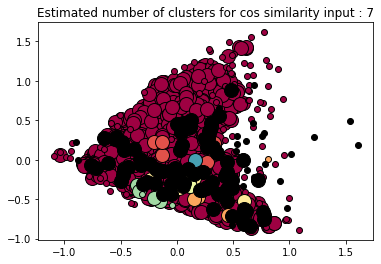

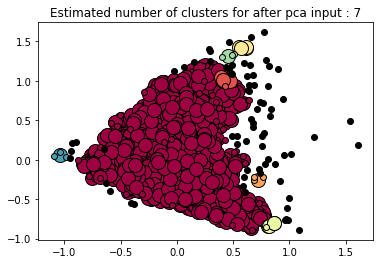

In [16]:
#sim
visualization(labels=labels_db_sim, n_clusters=7,  alg='DBSCAN',  data='cos similarity', core_samples_mask=core_samples_mask)
visualization(labels=labels_db_pca, n_clusters=7,  alg='DBSCAN',  data='after pca', core_samples_mask=core_samples_mask)

### 6.2 K-MEANS

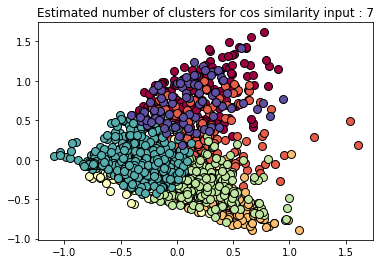

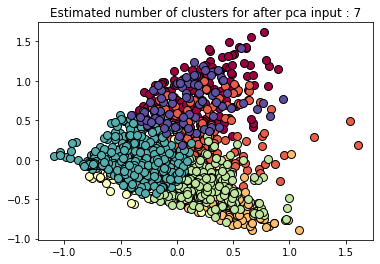

In [17]:
#sim
visualization(labels=labels_km_sim, n_clusters=7,  alg='K-MEANS',  data='cos similarity')
visualization(labels=labels_km_pca, n_clusters=7,  alg='K-MEANS',  data='after pca')

### 6.2 Agglomerative Clustering

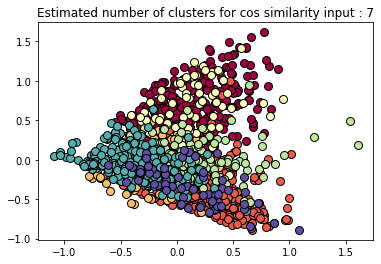

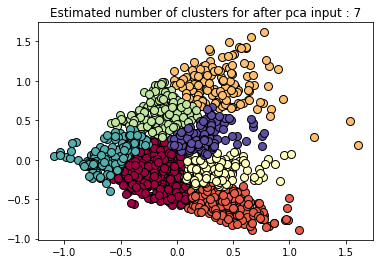

In [18]:
visualization(labels=labels_ac_sim, n_clusters=7,  alg='Agglomerative Clustering',  data='cos similarity')
visualization(labels=labels_ac_pca, n_clusters=7,  alg='Agglomerative Clustering',  data='after pca')

## 7. Evaluation
As the ground truth labels are not known, I choose the Calinski-Harabasz index (also known as the Variance Ratio Criterion) and the Davies-Bouldin index to evaluate the models.  
* **Calinski-Harabasz Index:** The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). **A higher Calinski-Harabasz score** relates to a model with better defined clusters.
* **Davies-Bouldin Index:** This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. **A lower Davies-Bouldin score** relates to a model with better separation between the clusters.
>Both Calinski-Harabasz Index and Davies-Bouldin Index are generally higher for for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.

In [19]:
def evaluate(alg, data, input, labels):
    from sklearn import metrics
    print(f'The Calinski-Harabasz Index for {alg} on {data} input is {metrics.calinski_harabasz_score(input, labels)}')
    print(f'The Davies-Bouldin Index for {alg} on {data} input is {metrics.davies_bouldin_score(input, labels)}')
    return

### 7.1 DBSCAN

In [20]:
evaluate("DBSCAN", "cos similarity", cos_sim, labels_db_sim)
evaluate("DBSCAN", "after PCA", reduced_data, labels_db_pca)

The Calinski-Harabasz Index for DBSCAN on cos similarity input is 4.686283531589143
The Davies-Bouldin Index for DBSCAN on cos similarity input is 3.56747083306034
The Calinski-Harabasz Index for DBSCAN on after PCA input is 34.91858546320072
The Davies-Bouldin Index for DBSCAN on after PCA input is 1.0970885367465084


### 7.2 K-MEANS

In [21]:
evaluate("K-MEANS", "cos similarity", cos_sim, labels_km_sim)
evaluate("K-MEANS", "after PCA", reduced_data, labels_km_pca)

The Calinski-Harabasz Index for K-MEANS on cos similarity input is 57.14244570327677
The Davies-Bouldin Index for K-MEANS on cos similarity input is 3.2596077666581293
The Calinski-Harabasz Index for K-MEANS on after PCA input is 533.1964692362727
The Davies-Bouldin Index for K-MEANS on after PCA input is 2.889072199926749


### 7.3 Agglomerative Clustering

In [22]:
evaluate("Agglomerative Clustering", "cos similarity", cos_sim, labels_ac_sim)
evaluate("Agglomerative Clustering", "after PCA", reduced_data, labels_ac_pca)

The Calinski-Harabasz Index for Agglomerative Clustering on cos similarity input is 48.805019735698956
The Davies-Bouldin Index for Agglomerative Clustering on cos similarity input is 3.2833624441909763
The Calinski-Harabasz Index for Agglomerative Clustering on after PCA input is 1164.6156207312615
The Davies-Bouldin Index for Agglomerative Clustering on after PCA input is 0.9163815182652734
